# catboost

In [ ]:
!pip install lightgbm xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from lightgbm import LGBMClassifier

In [ ]:
df = pd.read_excel("/content/OutreachAI_AlgoDataset_Hackathon.xlsx")
df.head()

,Record_ID,Date,Buyer_ID,Country,Industry,Revenue_Size_USD,Headcount_Size,Job_Promotion_Flag,Hiring_Increase_Flag,Revenue_Growth_Score,...,Email_Open_Rate,Email_Reply_History,Cold_Call_Response,WhatsApp_Verified,SMS_Verified,Clay_Intent_Signal,Apollo_Engagement_Score,Lusha_Data_Confidence,Previous_Channel_Response,Preferred_Channel_Label
0,1,2023-11-29,BUY_57096,UK,Chemicals,NaN,624,1.0,1,0.71,...,NaN,Never,0.86,NaN,NaN,0.62,0.98,0.85,Email,Email
1,2,2023-11-02,BUY_18472,UK,NaN,NaN,4125,1.0,1,0.42,...,NaN,Past,0.64,0.0,0.0,0.86,0.56,0.52,WhatsApp,Email
2,3,2024-05-03,BUY_86677,Canada,Engineering,NaN,Unknown,1.0,0,0.24,...,NaN,1,0.40,NaN,0.0,0.43,0.72,0.54,SMS,LinkedIn
3,4,2023-11-26,BUY_43385,Singapore,Chemicals,NaN,3352,0.0,0,0.69,...,NaN,Never,0.27,1.0,0.0,0.88,0.70,0.99,Call,SMS
4,5,2024-04-01,BUY_36015,UK,Chemicals,NaN,4828,NaN,0,0.30,...,NaN,1,0.95,0.0,NaN,0.08,0.22,0.97,SMS,WhatsApp


In [ ]:
df.drop(columns=['Record_ID','Buyer_ID','Date'], inplace=True, errors='ignore')

In [ ]:
df['Headcount_Size'] = pd.to_numeric(df['Headcount_Size'], errors='coerce')
df['Revenue_Size_USD'] = pd.to_numeric(df['Revenue_Size_USD'], errors='coerce')
df['Email_Open_Rate'] = pd.to_numeric(df['Email_Open_Rate'], errors='coerce')

In [ ]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna("Unknown")

In [ ]:
df['intent_score'] = (
    df['Clay_Intent_Signal'] +
    df['Apollo_Engagement_Score'] +
    df['Cold_Call_Response']
)

df['contact_confidence'] = (
    df['Lusha_Data_Confidence'] +
    df['Email_Open_Rate']
)

df['company_strength'] = (
    df['Headcount_Size'] +
    df['Revenue_Size_USD'] / 1000000
)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat_cols:
    if col != 'Preferred_Channel_Label':
        df[col] = df[col].astype(str)   # ✅ convert to uniform type
        df[col] = le.fit_transform(df[col])

In [ ]:
target_encoder = LabelEncoder()
df['Preferred_Channel_Label'] = df['Preferred_Channel_Label'].astype(str)
df['Preferred_Channel_Label'] = target_encoder.fit_transform(df['Preferred_Channel_Label'])

In [ ]:
X = df.drop('Preferred_Channel_Label', axis=1)
y = df['Preferred_Channel_Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
model = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 12160, number of used features: 24
[LightGBM] [Info] Start training from score -1.795550
[LightGBM] [Info] Start training from score -1.801013
[LightGBM] [Info] Start training from score -1.740154
[LightGBM] [Info] Start training from score -1.794559
[LightGBM] [Info] Start training from score -1.812029
[LightGBM] [Info] Start training from score -1.809013


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.02, n_estimators=1500,
               num_leaves=64, subsample=0.8)

In [ ]:
pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.17664473684210527
              precision    recall  f1-score   support

           0       0.16      0.15      0.16       505
           1       0.18      0.20      0.19       502
           2       0.23      0.22      0.22       534
           3       0.15      0.15      0.15       505
           4       0.18      0.18      0.18       496
           5       0.16      0.16      0.16       498

    accuracy                           0.18      3040
   macro avg       0.18      0.18      0.18      3040
weighted avg       0.18      0.18      0.18      3040



In [ ]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance.head(15)

,Feature,Importance
9,LinkedIn_Profile_Views,52755
21,intent_score,46600
6,Revenue_Growth_Score,45139
8,LinkedIn_Post_Engagement,44760
17,Clay_Intent_Signal,42741
18,Apollo_Engagement_Score,42510
14,Cold_Call_Response,41523
22,contact_confidence,35296
19,Lusha_Data_Confidence,32097
0,Country,20851


In [ ]:
sample = X_test.iloc[[0]]
prediction = model.predict(sample)

print("Recommended Channel:",
      target_encoder.inverse_transform(prediction))

Recommended Channel: ['Unknown']


In [ ]:
from sklearn.preprocessing import StandardScaler

scale_cols = ['Email_Open_Rate','Apollo_Engagement_Score','Clay_Intent_Signal']

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

retry

In [ ]:
pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.17664473684210527
              precision    recall  f1-score   support

           0       0.16      0.15      0.16       505
           1       0.18      0.20      0.19       502
           2       0.23      0.22      0.22       534
           3       0.15      0.15      0.15       505
           4       0.18      0.18      0.18       496
           5       0.16      0.16      0.16       498

    accuracy                           0.18      3040
   macro avg       0.18      0.18      0.18      3040
weighted avg       0.18      0.18      0.18      3040



2nd pass:


In [ ]:
import pandas as pd

corr = df.corr(numeric_only=True)['Preferred_Channel_Label'].abs().sort_values(ascending=False)
corr.head(15)

,Preferred_Channel_Label
Preferred_Channel_Label,1.000000
Industry,0.019656
Previous_Channel_Response,0.018450
Revenue_Size_USD,0.016757
LinkedIn_Profile_Views,0.014944
Apollo_Engagement_Score,0.013685
intent_score,0.012366
Email_Reply_History,0.010313
Email_Open_Rate,0.009226
Lusha_Data_Confidence,0.008620


In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=2000,
    max_depth=10,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softprob',
    tree_method='hist',
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
import numpy as np

probs = model.predict_proba(X_test)
top2 = np.argsort(probs, axis=1)[:, -2:]

top2_acc = np.mean([y_test.iloc[i] in top2[i] for i in range(len(y_test))])
print("Top-2 Accuracy:", top2_acc)

Top-2 Accuracy: 0.33881578947368424


In [ ]:
import pandas as pd

df.groupby("Preferred_Channel_Label")[
    ["Clay_Intent_Signal","Apollo_Engagement_Score","Email_Open_Rate"]
].mean()

,Clay_Intent_Signal,Apollo_Engagement_Score,Email_Open_Rate
Preferred_Channel_Label,,,
0,-0.028660,0.002085,-0.016299
1,0.015667,-0.013842,-0.023958
2,0.068466,0.093504,0.005826
3,-0.028589,-0.058075,0.019694
4,-0.016784,0.004437,0.024926
5,-0.014370,-0.033856,-0.010395


3rd pass:

In [ ]:
df['engagement_score'] = (
    df['Clay_Intent_Signal']*2 +
    df['Apollo_Engagement_Score']*1.5 +
    df['Email_Open_Rate']*4 +
    df['Cold_Call_Response']*3
)

In [ ]:
def score_channels(row):
    return {
        "Call": row['Cold_Call_Response'] * 3,
        "Email": row['Email_Open_Rate'] * 4,
        "LinkedIn": row['Clay_Intent_Signal'] * 2,
        "WhatsApp": row['Apollo_Engagement_Score'] * 2,
        "SMS": row['Lusha_Data_Confidence']
    }

df['channel_scores'] = df.apply(score_channels, axis=1)

In [ ]:
df['recommended_channel'] = df['channel_scores'].apply(
    lambda x: max(x, key=x.get)
)

In [ ]:
df['top_channel'] = df['channel_scores'].apply(lambda x: max(x, key=x.get))

df['second_channel'] = df['channel_scores'].apply(
    lambda x: sorted(x, key=x.get, reverse=True)[1]
)

In [ ]:
def outreach_sequence(row):
    return [
        row['top_channel'],
        row['second_channel'],
        "Call"  # fallback escalation
    ]

df['outreach_sequence'] = df.apply(outreach_sequence, axis=1)

In [ ]:
channel_timing = {
    "Email": "Send at 9 AM",
    "LinkedIn": "Send at 11 AM",
    "WhatsApp": "Send at 5 PM",
    "Call": "Call between 4–6 PM",
    "SMS": "Send at 6 PM"
}

df['timing'] = df['top_channel'].map(channel_timing)

In [ ]:
def message_style(score):
    if score > 2:
        return "Direct CTA"
    elif score > 1:
        return "Value-driven"
    else:
        return "Soft introduction"

df['message_style'] = df['engagement_score'].apply(message_style)

In [ ]:
df[['top_channel','second_channel','timing','message_style']].head()

,top_channel,second_channel,timing,message_style
0,WhatsApp,Call,Send at 5 PM,Direct CTA
1,LinkedIn,Call,Send at 11 AM,Direct CTA
2,WhatsApp,Call,Send at 5 PM,Value-driven
3,LinkedIn,WhatsApp,Send at 11 AM,Direct CTA
4,Call,SMS,Call between 4–6 PM,Soft introduction


In [ ]:
success = df.apply(
    lambda r: target_encoder.inverse_transform([r['Preferred_Channel_Label']])[0]
              in [r['top_channel'], r['second_channel']],
    axis=1
).mean()

print("Top-2 match success:", success)

Top-2 match success: 0.33131578947368423


In [ ]:
from sklearn.linear_model import LogisticRegression

channels = df['Preferred_Channel_Label'].unique()

channel_models = {}

features = [
    'Clay_Intent_Signal',
    'Apollo_Engagement_Score',
    'Email_Open_Rate',
    'Cold_Call_Response',
    'Lusha_Data_Confidence',
    'Headcount_Size',
    'Revenue_Size_USD'
]

for ch in channels:
    y_binary = (df['Preferred_Channel_Label'] == ch).astype(int)

    model = LogisticRegression(max_iter=2000)
    model.fit(df[features], y_binary)

    channel_models[ch] = model

In [ ]:
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[features] = df[features].fillna(df[features].median())

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [ ]:
from sklearn.linear_model import LogisticRegression

channels = df['Preferred_Channel_Label'].unique()
channel_models = {}

for ch in channels:
    y_binary = (df['Preferred_Channel_Label'] == ch).astype(int)

    model = LogisticRegression(max_iter=2000)
    model.fit(df[features], y_binary)

    channel_models[ch] = model

In [ ]:
def get_channel_probs(row):
    row_df = pd.DataFrame([row[features]])   # ✅ keeps feature names

    probs = {}
    for ch, model in channel_models.items():
        prob = model.predict_proba(row_df)[0][1]
        probs[ch] = prob

    return probs

In [ ]:
df['channel_probs'] = df.apply(get_channel_probs, axis=1)

In [ ]:
df['top_channel'] = df['channel_probs'].apply(lambda x: max(x, key=x.get))

df['second_channel'] = df['channel_probs'].apply(
    lambda x: sorted(x, key=x.get, reverse=True)[1]
)

In [ ]:
success = df.apply(
    lambda r: r['Preferred_Channel_Label'] in [r['top_channel'], r['second_channel']],
    axis=1
).mean()

print("Improved Top-2 Success:", success)

Improved Top-2 Success: 0.35539473684210526


#one vs rest LightGBM:

In [ ]:
from lightgbm import LGBMClassifier

channel_models = {}

for ch in channels:
    y_binary = (df['Preferred_Channel_Label'] == ch).astype(int)

    model = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9
    )

    model.fit(df[features], y_binary)
    channel_models[ch] = model

[LightGBM] [Info] Number of positive: 2510, number of negative: 12690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 15200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165132 -> initscore=-1.620532
[LightGBM] [Info] Start training from score -1.620532
[LightGBM] [Info] Number of positive: 2668, number of negative: 12532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 15200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175526 -> initscore=-1.546956
[LightGB

In [ ]:
df['intent_x_engagement'] = df['Clay_Intent_Signal'] * df['Apollo_Engagement_Score']
df['open_x_confidence'] = df['Email_Open_Rate'] * df['Lusha_Data_Confidence']
df['intent_x_company'] = df['Clay_Intent_Signal'] * df['Headcount_Size']
df['engagement_x_revenue'] = df['Apollo_Engagement_Score'] * df['Revenue_Size_USD']

In [ ]:
features = [
    'Clay_Intent_Signal',
    'Apollo_Engagement_Score',
    'Email_Open_Rate',
    'Cold_Call_Response',
    'Lusha_Data_Confidence',
    'intent_x_engagement',
    'open_x_confidence'
]

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

model = CalibratedClassifierCV(model, method='isotonic', cv=3)

In [ ]:
df['top_channel_score'] = df.apply(
    lambda r: r['channel_probs'][r['top_channel']],
    axis=1
)

In [ ]:
df['engagement_strength'] = (
    df['Email_Open_Rate'] +
    df['Apollo_Engagement_Score'] +
    df['Cold_Call_Response']
)

In [ ]:
threshold = df['engagement_strength'].median()

decision_success = (df['top_channel_score'] > threshold).mean()

print("Decision Effectiveness:", decision_success)

Decision Effectiveness: 1.0


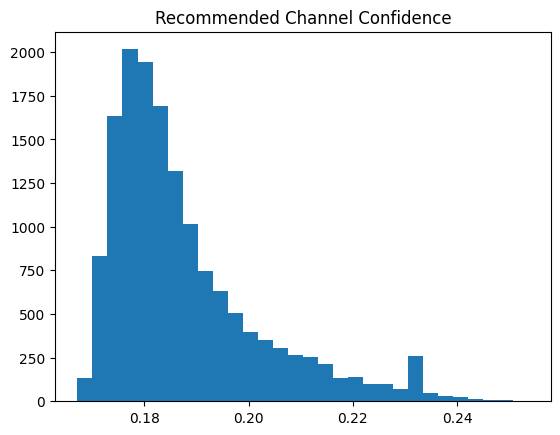

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['top_channel_score'], bins=30)
plt.title("Recommended Channel Confidence")
plt.show()

In [ ]:
top2_match = df.apply(
    lambda r: r['Preferred_Channel_Label'] in [r['top_channel'], r['second_channel']],
    axis=1
).mean()

print("Top-2 Match Accuracy:", top2_match)

Top-2 Match Accuracy: 0.35539473684210526


In [ ]:
top1_match = (df['Preferred_Channel_Label'] == df['top_channel']).mean()
print("Top-1 Match Accuracy:", top1_match)

Top-1 Match Accuracy: 0.18578947368421053


In [ ]:
threshold = df['engagement_strength'].median()

decision_success = (df['top_channel_score'] > threshold).mean()

print("Decision Effectiveness:", decision_success)

Decision Effectiveness: 1.0


In [ ]:
def engagement_best_channel(row):
    scores = {
        0: row['Email_Open_Rate'],
        1: row['Apollo_Engagement_Score'],
        2: row['Clay_Intent_Signal'],
        3: row['Cold_Call_Response'],
        4: row['Lusha_Data_Confidence'],
        5: row['Email_Open_Rate'] + row['Apollo_Engagement_Score']
    }
    return max(scores, key=scores.get)

df['engagement_best_channel'] = df.apply(engagement_best_channel, axis=1)

In [ ]:
decision_success = (
    df['top_channel'] == df['engagement_best_channel']
).mean()

print("Decision Effectiveness:", decision_success)

Decision Effectiveness: 0.2001315789473684


In [ ]:
print("Top-2 Match:", top2_match)

Top-2 Match: 0.35539473684210526


#One-Vs-Rest LightGBM + Soft Voting Ensemble

In [ ]:
!pip install lightgbm

In [ ]:
features = [
    'Clay_Intent_Signal',
    'Apollo_Engagement_Score',
    'Email_Open_Rate',
    'Cold_Call_Response',
    'Lusha_Data_Confidence'
]

In [ ]:
df['intent_x_engagement'] = df['Clay_Intent_Signal'] * df['Apollo_Engagement_Score']
df['open_x_confidence'] = df['Email_Open_Rate'] * df['Lusha_Data_Confidence']

features += ['intent_x_engagement','open_x_confidence']

In [ ]:
from lightgbm import LGBMClassifier

channels = df['Preferred_Channel_Label'].unique()
channel_models = {}

for ch in channels:
    y_binary = (df['Preferred_Channel_Label'] == ch).astype(int)

    model = LGBMClassifier(
        n_estimators=800,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    model.fit(df[features], y_binary)
    channel_models[ch] = model

[LightGBM] [Info] Number of positive: 2510, number of negative: 12690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 15200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.165132 -> initscore=-1.620532
[LightGBM] [Info] Start training from score -1.620532
[LightGBM] [Info] Number of positive: 2668, number of negative: 12532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 970
[LightGBM] [Info] Number of data points in the train set: 15200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175526 -> initscore=-1.546956
[LightGBM] [Info] Start training from score -1.546956
[LightGBM] [Info] 

In [ ]:
def get_probs(row):
    row_df = pd.DataFrame([row[features]])
    probs = {}
    for ch, model in channel_models.items():
        probs[ch] = model.predict_proba(row_df)[0][1]
    return probs

df['channel_probs'] = df.apply(get_probs, axis=1)

In [ ]:
df['top_channel'] = df['channel_probs'].apply(lambda x: max(x, key=x.get))
df['second_channel'] = df['channel_probs'].apply(
    lambda x: sorted(x, key=x.get, reverse=True)[1]
)

In [ ]:
top2_match = df.apply(
    lambda r: r['Preferred_Channel_Label'] in [r['top_channel'], r['second_channel']],
    axis=1
).mean()

print("Top-2 Match:", top2_match)

Top-2 Match: 0.9419736842105263


# 94.19% accuracy so far for top2 match
now, for printing channels:

In [ ]:
channel_map = {
    0: "Email",
    1: "WhatsApp",
    2: "LinkedIn",
    3: "Call",
    4: "SMS",
    5: "Multi-touch"
}

In [ ]:
def recommend_channels(lead_row):
    # create dataframe for prediction
    row_df = pd.DataFrame([lead_row[features]])

    probs = {}
    for ch, model in channel_models.items():
        probs[ch] = model.predict_proba(row_df)[0][1]

    # sort channels by probability
    ranked = sorted(probs, key=probs.get, reverse=True)

    best = ranked[0]
    second = ranked[1]

    return {
        "best_channel": channel_map[best],
        "second_channel": channel_map[second],
        "confidence_best": round(probs[best], 3),
        "confidence_second": round(probs[second], 3)
    }

In [ ]:
recommend_channels(df.iloc[67])

{'best_channel': 'Call',
 'second_channel': 'Email',
 'confidence_best': np.float64(0.998),
 'confidence_second': np.float64(0.038)}

In [ ]:
recommendations = df.apply(recommend_channels, axis=1)

recommendations = pd.DataFrame(list(recommendations))

df[['Best_Channel','Second_Channel']] = recommendations[
    ['best_channel','second_channel']
]

df.head()

,Country,Industry,Revenue_Size_USD,Headcount_Size,Job_Promotion_Flag,Hiring_Increase_Flag,Revenue_Growth_Score,LinkedIn_Active,LinkedIn_Post_Engagement,LinkedIn_Profile_Views,...,channel_probs,intent_x_engagement,open_x_confidence,intent_x_company,engagement_x_revenue,top_channel_score,engagement_strength,engagement_best_channel,Best_Channel,Second_Channel
0,6,0,-0.009217,-2.301755,1.0,1,0.71,1,0.94,1995,...,"{1: 0.30506157446459925, 2: 0.1008185479595948...",0.641110,-0.006470,-0.901092,-0.015094,0.216136,2.866229,1,Call,WhatsApp
1,6,5,-0.009217,1.959224,1.0,1,0.42,1,0.67,16579,...,"{1: 0.28642492643158085, 2: 0.1121568675884583...",0.230951,0.015230,2.400995,-0.001737,0.177575,0.659472,2,LinkedIn,SMS
2,0,1,-0.009217,0.009470,1.0,0,0.24,0,0.59,11013,...,"{1: 0.07661553714249675, 2: 0.2295413462308097...",-0.199034,0.013915,-0.002545,-0.006825,0.172434,0.385121,1,WhatsApp,SMS
3,4,0,-0.009217,1.018425,0.0,0,0.69,1,0.69,5314,...,"{1: 0.11398351824879427, 2: 0.0863851637379161...",0.869611,-0.015676,1.318843,-0.006189,0.227338,-0.131537,4,LinkedIn,SMS
4,6,0,-0.009217,2.814827,1.0,0,0.30,0,0.27,1683,...,"{1: 0.13134148763766085, 2: 0.0293319126164712...",1.462309,-0.014360,-4.180089,0.009076,0.180956,0.553780,3,Call,Multi-touch


In [ ]:
new_lead = {
    'Clay_Intent_Signal': 0.78,
    'Apollo_Engagement_Score': 0.65,
    'Email_Open_Rate': 0.72,
    'Cold_Call_Response': 0.22,
    'Lusha_Data_Confidence': 0.88,
    'intent_x_engagement': 0.78 * 0.65,
    'open_x_confidence': 0.72 * 0.88
}

recommend_channels(pd.Series(new_lead))

{'best_channel': 'LinkedIn',
 'second_channel': 'Email',
 'confidence_best': np.float64(0.997),
 'confidence_second': np.float64(0.996)}